#### TODO:

- move certain functions to src code and clean up notebook
- fill in documentation to make this easier to walk through during the workshop

- at end put instance of SA with 100000 iterations to show that enumeration would get you same optimal solution 
- separate approaches to two nbs


- Could be worth using a super simple example problem to illustrate what an objective function and mathematically formulated constraint are when you introduce the optimization model at the top of the workshop intro. I don't know how familiar those concepts are to people. 

- You could also tie it back to ML - loss functions in ML are fundamentally objective functions, and training a model is solving the optimization problem (typically with heuristics) to minimize the loss function subject to the constraints of the model architecture.


In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
sb.set_style("dark")

sys.path.append(os.path.join(os.getcwd(), '..','src'))

In [2]:
import optimal_gardening as og 

## Problem Setup

### Plant Info

In [3]:
plant_info = pd.read_csv('../data/plant_data.csv')
plant_info.index.name = 'plant_index'
plants = plant_info.name.to_numpy()
plant_index = plant_info.index.to_numpy()
num_plants = len(plants)

display(plant_info.head())
print(f'there are {num_plants} different types of plants')
print(f'plant names: {plants}')
print(f'plant index: {plant_index}')

,name,sun,perennial,problem_plant,evan,gina,liesse,lizzie,jack
plant_index,,,,,,,,,
0,Arugula,Partial shade,0,0,6,7,5,9,7
1,Asparagus,Partial shade,1,0,7,4,1,4,2
2,Banana peppers,Full sun,0,0,7,4,8,4,4
3,Basil,Full sun,0,0,8,7,3,1,1
4,Bell peppers,Full sun,0,0,7,4,5,1,7


there are 36 different types of plants
plant names: ['Arugula' 'Asparagus' 'Banana peppers' 'Basil' 'Bell peppers'
 'Blueberries' 'Bok choy' 'Broccoli' 'Brussel sprouts' 'Butternut squash'
 'Carrots' 'Cayene peppers' 'Celery' 'Chives' 'Cilantro' 'Cucumbers'
 'Dill' 'Eggplant' 'Green beans' 'Kale' 'Lavender' 'Leeks' 'Lettuce'
 'Onions' 'Oregano' 'Parsley' 'Potatoes' 'Pumpkins' 'Rasberries'
 'Rosemary' 'Strawberries' 'Sweet potatoes' 'Thai basil' 'Tomatoes'
 'Watermelon' 'Zucchini']
plant index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]


In [4]:
#other relevant plant info
plant_sun_req = plant_info.sun.to_numpy()
perennials = plant_info[plant_info.perennial==1].index.to_list()
problem_plants = plant_info[plant_info.problem_plant==1].index.to_list()

print(problem_plants)
print(plant_info.iloc[problem_plants[0]]['name'])

[33]
Tomatoes


In [5]:
#calculate weighted average preference for each plant
family = ['evan','gina','liesse','lizzie','jack']
plant_info['avg_pref'] = np.average(plant_info[family],axis=1,weights=[.5,.5,0,0,0])
plant_info.drop(family,axis=1,inplace=True)
preferences = plant_info.avg_pref.to_numpy()

print(preferences)

[ 6.5  5.5  5.5  7.5  5.5  5.5  5.5  5.5  8.   8.5  6.   5.   4.   6.
  2.5  7.5  5.   4.   8.   4.5  5.   5.   5.5  5.5  5.5  5.   6.   5.
 10.   5.5  7.   6.   7.   7.   5.5  4.5]


### Bed Info

In [6]:
bed_info = pd.read_csv('../data/bed_data.csv')
bed_info.index.name = 'bed_index'
beds = bed_info.bed.to_numpy()
bed_index = bed_info.index.to_numpy()
bed_sun_req = bed_info.sun.to_numpy()
num_beds = len(beds)

display(bed_info.head())
print(f'there are {num_beds} garden beds')
print(f'bed names: {beds}')
print(f'bed index: {bed_index}')

,bed,sun,x,y
bed_index,,,,
0,1,Full sun,0,0
1,2,Partial sun,1,0
2,3,Partial shade,2,0
3,4,Full sun,0,1
4,5,Partial sun,1,1


there are 42 garden beds
bed names: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
bed index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]


<AxesSubplot:>

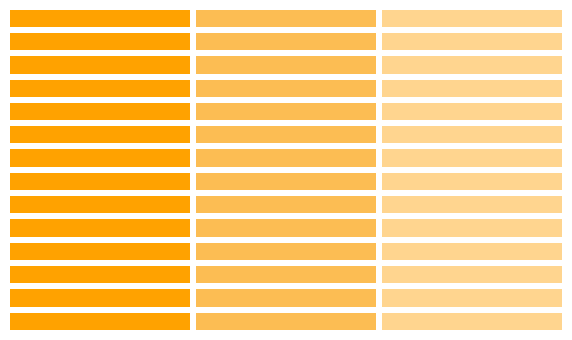

In [7]:
og.visualize_garden(bed_info)

### Time Dimension

In [8]:
#time dimension
num_years = 3
years = np.array(range(1,num_years+1))
year_index = np.array(range(num_years))

print(f'we are planning {num_years} years out')
print(f'years: {years}')
print(f'year index: {year_index}')

we are planning 3 years out
years: [1 2 3]
year index: [0 1 2]


### Possible Solutions
Here we can look at the possible solutions to the problem as a graph. Not all edges can be traversed (i.e. certain plants cannot be assigned to certain beds due to the sun constraint). 

In [9]:
print(f'{num_plants*num_beds*num_years} binary decisions need to be made.')

4536 binary decisions need to be made.


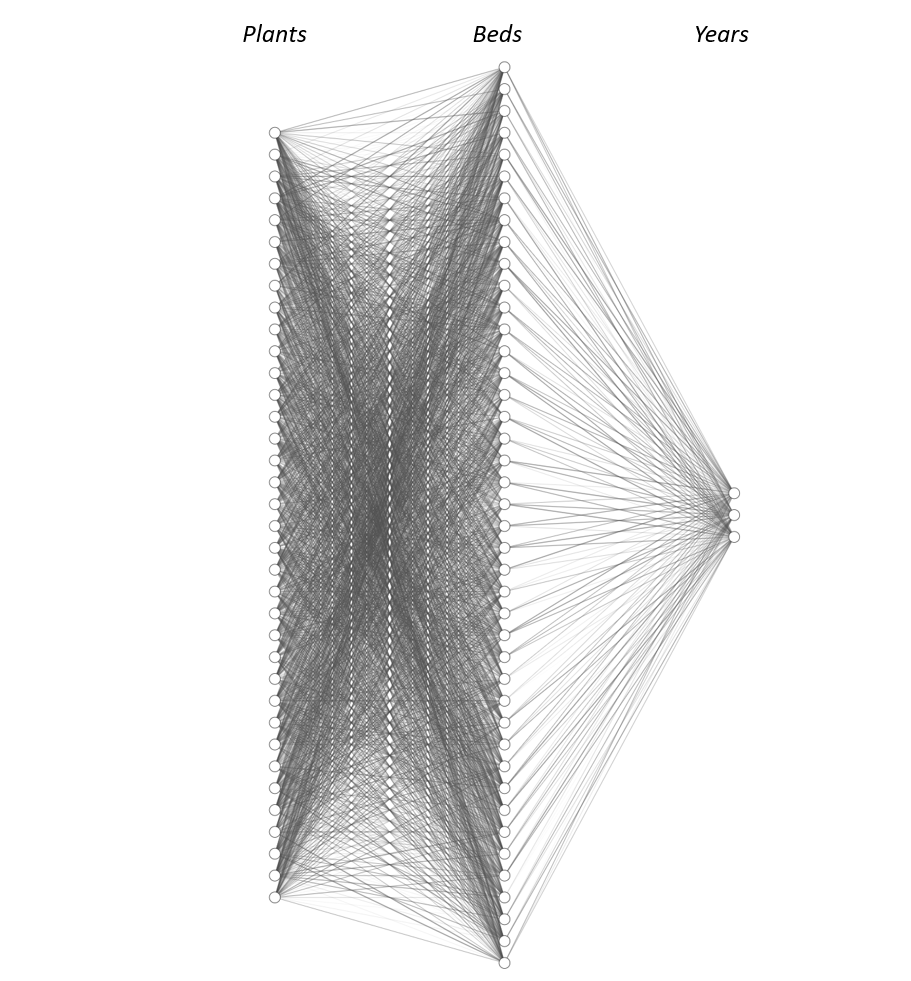

In [10]:
Image(os.path.join(os.getcwd(),'..','img','solution_space_viz.png'))

## First Approach: Heuristics
A good initial approach is to implement a heuristic. We will use simulated annealing, but will follow a recipe that applies to most, if not all metaheuristic search techniques. 

- 1: An initial starting point 
- 2: A search strategy 
- 3: An objective
- 4: A solution acceptance criteria 

### 1. An Initial Starting Point
This can be a random initial solution or the ouput of another heuristic (e.g. a greedy search method). 

In [11]:
#for keeping track of what axis is which
plant_axis = 0
bed_axis = 1
year_axis = 2

#initialize plan. no plants in any bed
initial_plan = np.zeros(shape=(num_plants,num_beds,num_years))

#put a random crop in each bed for all years
for bed in bed_index:
    plant = np.random.choice(plant_index)
    initial_plan[plant][bed] = 1
    
print(f'plan shape: {initial_plan.shape}')
print('initial plan for the first bed in the first year')
print(initial_plan[:,0,0])

plan shape: (36, 42, 3)
initial plan for the first bed in the first year
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### 2. A search strategy
A well-defined way of moving from one candidate solution to another **feasible** solution within the solution space. The search strategy will be stochastic, but in generating a neighboring solution we will only tweak our solution in some minor way. 

In [55]:
def make_neighbor(plan):
    """
    iteration: 
    cycle_size: 
    """
    #pick a random plant
    plant = np.random.choice(plant_index)
    #pick a random bed
    bed = np.random.choice(bed_index)
    #pick a random year
    year = np.random.choice(year_index)

    #implement decision
    new_plan = plan.copy()
    new_plan[:,bed,year] = np.zeros(shape=(num_plants)) #zero out previous decision for the bed in the year
    new_plan[plant,bed,year] = 1

    #enforce constraints
    new_plan = enforce_perennial_constraint(new_plan,plant,bed,year,perennials)
    new_plan = enforce_sun_constraint(new_plan,sun_constraint)
    new_plan = enforce_disease_constraint(new_plan,problem_plants)
        
    return new_plan

In [56]:
#initialize sun constraint
sun_constraint = np.ones(shape=(num_plants,num_beds,num_years))

for p in plant_index:
    for b in bed_index:
        p_sun = plant_sun_req[p]
        b_sun = bed_sun_req[b]
        if p_sun != b_sun:
            sun_constraint[p,b,:] = 0
            
def enforce_sun_constraint(plan,sun_constraint):
    """
    !!!!update
    Scans beds and plants, kills any plant that is in a bed that does not match its sun requirement.
    """
    return plan*sun_constraint

def enforce_perennial_constraint(plan,plant,bed,year,perennials):
    perennial_plan = plan.copy()
   
    plant_last_year = perennial_plan[:,bed,year-1].argmax() #what was planted the year before

    #if the plant is a perennial, plant it this year and every year thereafter
    if plant in perennials:
        perennial_plan[:,bed,year:] = 0 # zeros out anything else that may have been planted in bed in current and subsequent years during a previous make_neighbor call
        perennial_plan[plant,bed,year:] = 1 #sets plant to 1 in bed every year after the current year
   
    #if what was planted already in this bed was a perennial, remove it from previous years
    elif plant_last_year in perennials:
        # perennial_plan[plant,bed,year:] = 0
        perennial_plan[plant_last_year,bed,:year] = 0

    return perennial_plan

def enforce_disease_constraint(plan,problem_plants):
    """#mask to determine if the same veg was planted in the same bed over multiple years. 
    Multiply mask by plan for disease prone plants. """
    disease_plan = plan.copy()
    same_veg_in_bed_yoy = disease_plan.cumsum(axis=year_axis)>1 
    disease_plan[problem_plants] = disease_plan[problem_plants]*(abs(1-same_veg_in_bed_yoy)[problem_plants])
    return disease_plan

### 3: An objective
A way of measuring the quality of a solution. We will 

In [57]:
#the most satisfied you could be (planting fruit or vegetable with highest preference in all beds every year)
max_yums = num_beds*num_years*np.max(preferences)

def compute_yummy_score(plan,preferences,max_yums):
    """Takes the weighted average of the preferences of each plant, weighted by the total qty of plants 
    in the current plan for each plant. Maximization encourages plants with higher preferences to be planted in higher quantities."""
    plan_yummy = plan.copy()
    plan_by_plant = plan_yummy.sum(axis=(bed_axis,year_axis))
    yums = round(np.dot(preferences,plan_by_plant)/max_yums*100,1)
    return yums

In [58]:
def compute_variety_score(plan,num_plants):
    """Sums the number of unique plants that are actually planted in the garden. Counts the number of plants that are being planted across all beds.
       Then counts the number of plants with non-zero planting plan. 
       Maximization encourages more unique plants to be planted."""
    plan_variety = plan.copy()
    num_plants_in_plan = (plan_variety.sum(axis=(bed_axis,year_axis)) > 0).sum()
    variety_score = round(num_plants_in_plan/num_plants*100,1)
    return variety_score

In [59]:
def get_objective(plan,weights):
    yummy_score = compute_yummy_score(plan,preferences,max_yums)
    variety_score = compute_variety_score(plan,num_plants)
    objective = (weights['yummy_score']*yummy_score
               + weights['variety_score']*variety_score)
    return (objective,{'objective':objective,'yummy_score':yummy_score,'variety_score':variety_score})

### 4: A solution acceptance criteria 
A way of deciding whether or not to accept a neighboring solution as the new current solution. This is where annealing and temperature comes in. Better solutions are always accepted. Worse solutions are probabalistically accepted based on the current temperature. The temperature starts out high and is lowered on a schedule. When the temperature is high, the probability of accepting a worse solution is high. As it is lowered, we move into local search. 
This allows us to search for a global optimum more widely before honing our search. 

$ e^\frac{(n-c)}{t} > U(0,1)$

When the temperature is high, there is more tolerance for accepting significantly worse solutions (i.e. numerator can be more negative)
<br>
When the temperature is low, there is less tolerance for the new solution to be significantly worse than the current solution.  

In [97]:
def decide_to_accept_neighbor(new_objective,current_objective,temperature,method='SA'):
    """"""
    if method=='SA':
        accept_neighbor = new_objective > current_objective or np.exp((new_objective-current_objective) / temperature) > np.random.uniform()

    if method=='LS':
        accept_neighbor = new_objective > current_objective 

    return accept_neighbor

### Bring it all together 

In [98]:
def optimize(initial_plan,weights,starting_temperature=10000,alpha=0.99,max_SA_iter=1000,method='SA'):

    current_plan = initial_plan.copy()
    current_objective,current_obj_values = get_objective(initial_plan,weights)
    
    best_plan = initial_plan.copy()
    best_objective = current_objective

    current_plan_obj_values = [(0,current_obj_values)]
    best_obj_values = [(0,current_obj_values)]
    
    temperature = starting_temperature

    for i in range(max_SA_iter):
        new_plan = make_neighbor(current_plan)
        
        new_objective,new_obj_values = get_objective(new_plan,weights)

        accept_neighbor = decide_to_accept_neighbor(new_objective,current_objective,temperature,method=method)
        if accept_neighbor:
            current_plan = new_plan.copy()
            current_objective = new_objective
            current_plan_obj_values.append((i,new_obj_values))
          
        #update the incumbent best plan, if the new objective beats the old objective
        if new_objective > best_objective:
            best_plan = new_plan.copy()
            best_objective = new_objective
            best_obj_values.append((i,new_obj_values))      
        
        #lower the temperature
        temperature = temperature*alpha   
    
    return best_plan,best_objective,best_obj_values,current_plan_obj_values

In [99]:
weights = {'yummy_score': 0.5, 'variety_score': 0.5}

#### Solve

In [115]:
best_plan,best_objective,best_obj_values,current_plan_obj_values = optimize(initial_plan,weights,max_SA_iter=10000,method='SA')

In [116]:
sa_results = best_obj_values[-1][1]
sa_obj = sa_results['objective']
sa_yums = sa_results['yummy_score']
sa_variety = sa_results['variety_score']

print(f'Overall SA Objective: {sa_obj}')
print(f'SA Yummy Score: {sa_yums}')
print(f'SA Variety Score: {sa_variety}')

Overall SA Objective: 88.1
SA Yummy Score: 76.2
SA Variety Score: 100.0


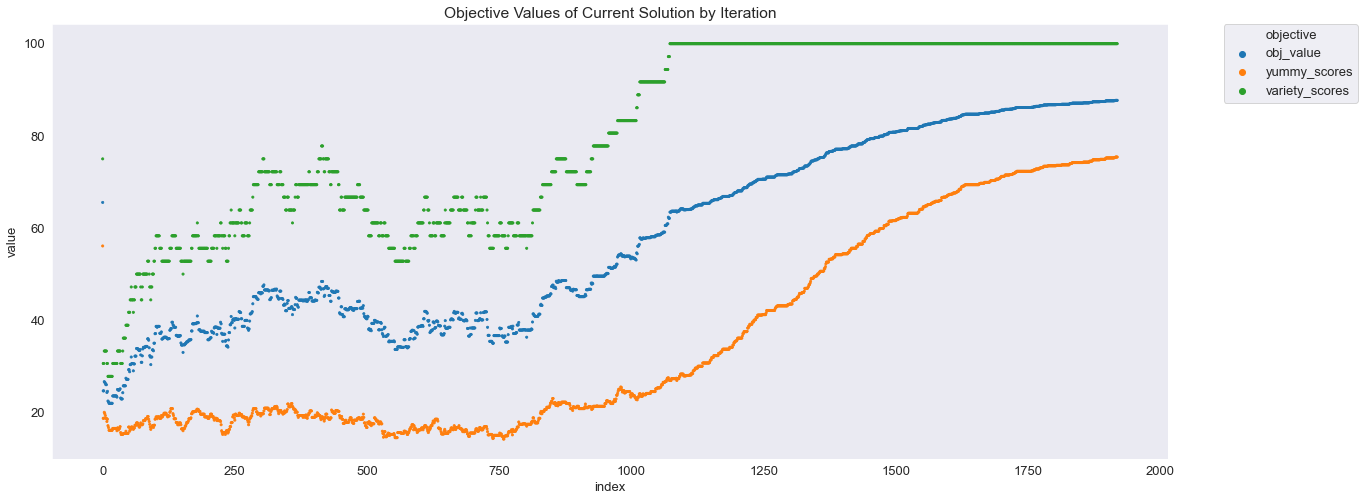

In [69]:
og.visualize_obj_iters(current_plan_obj_values)

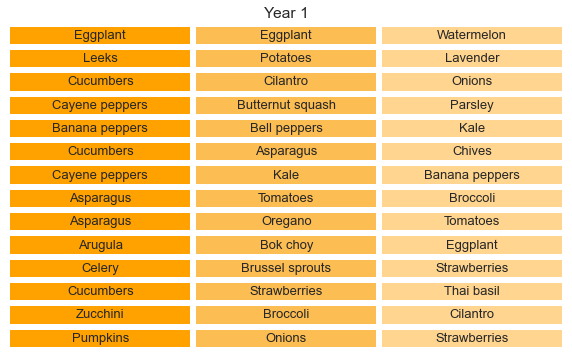

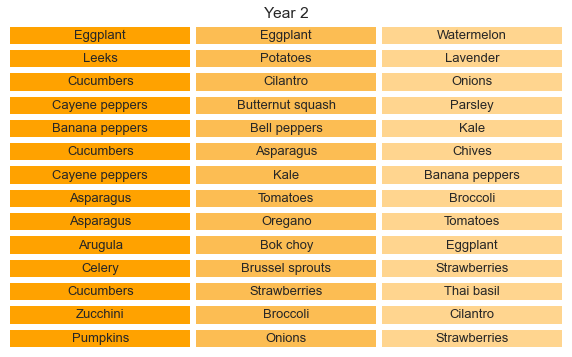

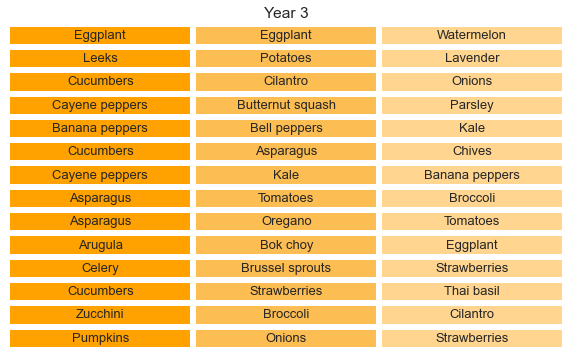

In [23]:
df_plan = og.annual_bed_plan(best_plan,bed_info,plant_info,bed_index,year_index)
og.visualize_plan(df_plan,bed_index,years)

### Mixed Integer Programming

In [24]:
import gurobipy as grb

### Gather Input Data

$P: \:Set \:of \:plants \:(indexed \:by \:p)$

In [25]:
plant_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35], dtype=int64)

$B: \:Set \:of \:beds \:(indexed \:by \:b)$

In [26]:
bed_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41], dtype=int64)

$T: \:Set \:of \:years \:(indexed \:by \:t)$

In [27]:
year_index

array([0, 1, 2])

$R: \:Set \:of \:plant \:preferences \:(indexed \:by \:p)$

In [28]:
preferences

array([ 6.5,  5.5,  5.5,  7.5,  5.5,  5.5,  5.5,  5.5,  8. ,  8.5,  6. ,
        5. ,  4. ,  6. ,  2.5,  7.5,  5. ,  4. ,  8. ,  4.5,  5. ,  5. ,
        5.5,  5.5,  5.5,  5. ,  6. ,  5. , 10. ,  5.5,  7. ,  6. ,  7. ,
        7. ,  5.5,  4.5])

$S: \:Ability \:to \:plant \:in \:bed \:given \:the \:sun \:constraint \:(indexed \:by \:p, \:b)$

In [29]:
#just take the sun constraint for the first year
sun = sun_constraint[:,:,0]
sun

array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

$P_{e}: \:Subset \:of \:plants \:that \:are \:perennials $

In [30]:
perennials

[1, 5, 13, 20, 24, 25, 28, 29, 30]

$P_{d}: \:Subset \:of \:plants \:that \:increase \:the \:risk \:of \:diseases \:if \:planted \:in \:same \:bed \:YoY$

In [31]:
problem_plants

[33]

$U: \:Maximum \:yummy \:score$

In [32]:
max_yums

1260.0

$G: \:Number \:of \:plants $

In [33]:
num_plants

36

$W: \:Objective \;Weights $

In [34]:
mip_weights = og.mip_weights

### Create a Model

In [35]:
try:
    m.reset()
except:
    m = grb.Model('optimus-veg')

Using license file C:\Users\elynch\gurobi.lic


### Add Decision Variables

$x \:(binary): \;Whether \;or \;not \;to \;grow \;plant \;(p) \;in \;bed \;(b) \;during \;year \;(t) $

In [36]:
#whether or not plant (p) is put in bed (b) in year (t). Binary
x = m.addVars(plant_index,bed_index,year_index,vtype=grb.GRB.BINARY)
print(f'Number of x variables: {len(x)}')
x

Number of x variables: 4536


{(0, 0, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 0, 1): <gurobi.Var *Awaiting Model Update*>,
 (0, 0, 2): <gurobi.Var *Awaiting Model Update*>,
 (0, 1, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 1, 1): <gurobi.Var *Awaiting Model Update*>,
 (0, 1, 2): <gurobi.Var *Awaiting Model Update*>,
 (0, 2, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 2, 1): <gurobi.Var *Awaiting Model Update*>,
 (0, 2, 2): <gurobi.Var *Awaiting Model Update*>,
 (0, 3, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 3, 1): <gurobi.Var *Awaiting Model Update*>,
 (0, 3, 2): <gurobi.Var *Awaiting Model Update*>,
 (0, 4, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 4, 1): <gurobi.Var *Awaiting Model Update*>,
 (0, 4, 2): <gurobi.Var *Awaiting Model Update*>,
 (0, 5, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 5, 1): <gurobi.Var *Awaiting Model Update*>,
 (0, 5, 2): <gurobi.Var *Awaiting Model Update*>,
 (0, 6, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 6, 1): <gurobi.Var *Awaiting Model Update*>,


$y \:(binary): \;Whether \;or \;not \;plant \;(p) \;is \;grown \;anywhere \;in \;any \;year $

In [37]:
#whether or not plant p is planted (anywhere)
y = m.addVars(plant_index,vtype=grb.GRB.BINARY)
print(f'Number of y variables: {len(y)}')
y

Number of y variables: 36


{0: <gurobi.Var *Awaiting Model Update*>,
 1: <gurobi.Var *Awaiting Model Update*>,
 2: <gurobi.Var *Awaiting Model Update*>,
 3: <gurobi.Var *Awaiting Model Update*>,
 4: <gurobi.Var *Awaiting Model Update*>,
 5: <gurobi.Var *Awaiting Model Update*>,
 6: <gurobi.Var *Awaiting Model Update*>,
 7: <gurobi.Var *Awaiting Model Update*>,
 8: <gurobi.Var *Awaiting Model Update*>,
 9: <gurobi.Var *Awaiting Model Update*>,
 10: <gurobi.Var *Awaiting Model Update*>,
 11: <gurobi.Var *Awaiting Model Update*>,
 12: <gurobi.Var *Awaiting Model Update*>,
 13: <gurobi.Var *Awaiting Model Update*>,
 14: <gurobi.Var *Awaiting Model Update*>,
 15: <gurobi.Var *Awaiting Model Update*>,
 16: <gurobi.Var *Awaiting Model Update*>,
 17: <gurobi.Var *Awaiting Model Update*>,
 18: <gurobi.Var *Awaiting Model Update*>,
 19: <gurobi.Var *Awaiting Model Update*>,
 20: <gurobi.Var *Awaiting Model Update*>,
 21: <gurobi.Var *Awaiting Model Update*>,
 22: <gurobi.Var *Awaiting Model Update*>,
 23: <gurobi.Var *Awa

### Add Objective

Maximize the weighted sum of the yummy score and the variety score

$maximize \;\; w_{1}\dfrac{\displaystyle\sum_{p=0}^{P}\displaystyle\sum_{b=0}^{B}\displaystyle\sum_{t=0}^{T}R_{p}x_{pbt}}{U} + w_{2}\dfrac{\displaystyle\sum_{p=0}^{P}y_{p}}{G} $

In [38]:
obj = m.setObjective((
    mip_weights['yummy_score']*grb.quicksum(preferences[p]*grb.quicksum(x[p,b,t] for b in bed_index for t in year_index) for p in plant_index)/max_yums + 
    mip_weights['variety_score']*(grb.quicksum(y[p] for p in plant_index)/num_plants)
                        ),sense=grb.GRB.MAXIMIZE)

### Add Constraints

Only allow at most one plant to be assigned to each bed in each year

$\displaystyle\sum_{p=0}^{P}x_{pbt} \leq 1  \;\;\;\;\forall \,b \in B , t \in T$

In [39]:
onePerBedConstraint = m.addConstrs((grb.quicksum(x[p,b,t] for p in plant_index) <= 1 for b in bed_index for t in year_index))

Plant cannot be grown in bed if the bed does not have the proper sun requirements to successfully grow the given plant

$x_{pbt} \leq S_{pb}  \;\;\;\;\forall \,p \in P_{e},\, b \in B ,\, t \in T$

In [40]:
sunConstraint = m.addConstrs((x[p,b,t]<=sun[p,b] for p in plant_index for b in bed_index for t in year_index))

Perennial plants must be assigned to the same bed once they are first planted

$x_{pbt} \geq x_{pbt-1}  \;\;\;\;\forall \,p \in P_{e},\, b \in B ,\, t = 1..T$

In [41]:
perennialConstraint = m.addConstrs(x[p,b,t] >= x[p,b,t-1] for p in plant_index if p in perennials for b in bed_index for t in year_index[1:])

Plants at risk of spreading soil-born diseases cannot be planted in the same bed year-over-year

$x_{pbt} \leq 1-x_{pbt-1}  \;\;\;\;\forall \,p \in P_{d},\, b \in B ,\, t = 1..T$

In [42]:
diseaseConstraint = m.addConstrs(x[p,b,t] <= 1 - x[p,b,t-1] for p in plant_index if p in problem_plants for b in bed_index for t in year_index[1:])

Relate x to y, so that planting x[p,b,t] anywhere at any point will trigger y[p] to be 1

$\displaystyle\sum_{b=0}^{B}\displaystyle\sum_{t=0}^{T} x_{pbt} \geq y_{p}  \;\;\;\;\forall \,p \in P$

In [43]:
#define y as it relates to x. You can only set y[p] to 1 if you actually plant it somewhere at some point
yxRelationConstraint = m.addConstrs((grb.quicksum(x[p,b,t] for b in bed_index for t in year_index)>= y[p] for p in plant_index))

### Solve

In [44]:
m.optimize()

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 5538 rows, 4572 columns and 15324 nonzeros
Model fingerprint: 0x9c60419d
Variable types: 0 continuous, 4572 integer (4572 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 1e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.3333333
Presolve removed 5417 rows and 3779 columns
Presolve time: 0.01s
Presolved: 121 rows, 793 columns, 1647 nonzeros
Found heuristic solution: objective 0.6257937
Variable types: 0 continuous, 793 integer (793 binary)

Root relaxation: objective 8.845238e-01, 290 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                       0.8845238    2.57480   191%     -    0s
     0     0          -    0         0.88452    0.88452  0.00%     -    0s


### Solution Analysis

In [45]:
#get solution in same format as heuristic approach
mip_plan = np.zeros(shape=(num_plants,num_beds,num_years))

for p in plant_index:
    for b in bed_index:
        for t in year_index:
            if x[p,b,t].x==1:
                mip_plan[p,b,t] = 1

In [46]:
mip_obs = round(m.getObjective().getValue()*100,1)
mip_yums = compute_yummy_score(mip_plan,preferences,max_yums)
mip_variety = compute_variety_score(mip_plan,num_plants)

print(f'Overall MIP Objective: {mip_obs}')
print(f'MIP Yummy Score: {mip_yums}')
print(f'MIP Variety Score: {mip_variety}')

Overall MIP Objective: 88.5
MIP Yummy Score: 76.9
MIP Variety Score: 100.0


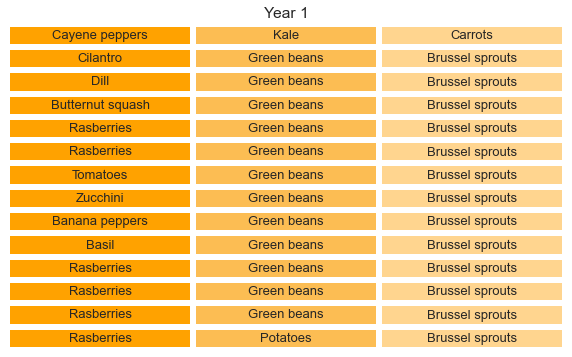

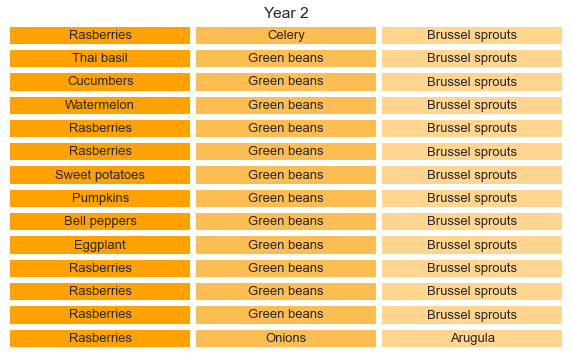

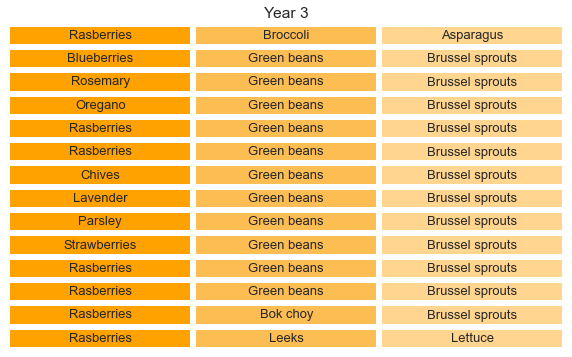

In [47]:
df_mip_plan = og.annual_bed_plan(mip_plan,bed_info,plant_info,bed_index,year_index)
og.visualize_plan(df_mip_plan,bed_index,years)

### Experiments:
- Show solution for 100% yummy
- Show simulated annealing vs local search
- Show we can reach optimality if given enough iterations
